# Practical assignment on Sparse variational dropout
Author of the assignment: Arsenii Ashukha, author of the tutorial: Nadezhda Chirkova

- [Link to a tutorial](https://github.com/yandexdataschool/mlhep2019/tree/master/slides/day-4/Bayesian/BNN.pdf)
- [Link to a solution](https://github.com/yandexdataschool/mlhep2019/tree/master/notebooks/day-4/Bayesian/SparseVD_solution.ipynb)
- Variational Dropout Sparsifies Deep Neural Networks https://arxiv.org/abs/1701.05369


In this task, we will train SparseVD model for a simple fully-connected network on a MNIST dataset. We will start with a short reminder about training neural networks in PyTorch and then implement necessary functions for SparseVD and incorporate them into model training.

## Training fully-connected network in pytorch

In [1]:
# Logger
# if you have problems with this import
# check that you are working with python3
# and downloaded logger.py file to the folder with this notebook
from logger import Logger

In [2]:
import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from logger import Logger
from torch.nn import Parameter
from torchvision import datasets, transforms

Load a dataset:

In [3]:
batch_size = 100
# define data preprocessing
tranform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize((0.1307,), (0.3081,))])
# load train and test datasets and wrap them into loaders (batch generators)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=tranform), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True,
    transform=tranform), batch_size=batch_size, shuffle=True)

Define a network:

In [4]:
class Net(nn.Module):
    def __init__(self,):
        # components of the model
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300,  10)

    def forward(self, x):
        # how to perform forward pass
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# define device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# make instance of the Net
model = Net().to(device)

Define loss:

In [7]:
lossfun = F.cross_entropy

Define optimizer:

In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Create logger instance:

In [9]:
fmt = {'tr_los': '3.1e', 'te_loss': '3.1e'}
logger = Logger('fc_net', fmt=fmt)

Define device and training procedure:

In [10]:
def train(train_loader, test_loader, model, lossfun, logger, device,
          optimizer, scheduler=None, epochs = 100, sparse=False):
    # we will need it for sparsification
    if sparse:
        kl_weight = 0.02

    for epoch in range(1, epochs + 1):
        # we will need it for sparsification
        if sparse:
            kl_weight = min(kl_weight+0.02, 1)
            logger.add_scalar(epoch, 'kl', kl_weight)
            lossfun.kl_weight = kl_weight
        if scheduler is not None:
            scheduler.step()
            logger.add_scalar(epoch, 'lr', scheduler.get_lr()[0])
        
        ### iterate over training batches, perform forward and backward pass and count metrics
        model.train()
        train_loss, train_acc = 0, 0 
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28*28)
            optimizer.zero_grad()

            output = model(data)
            pred = output.data.max(1)[1] 
            loss = lossfun(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss 
            train_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())

        logger.add_scalar(epoch, 'tr_los', train_loss / len(train_loader.dataset))
        logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)
        
        ### iterate over testing batches, perform forward pass and count metrics
        model.eval()
        test_loss, test_acc = 0, 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28*28)
            output = model(data)
            test_loss += float(lossfun(output, target))
            pred = output.data.max(1)[1] 
            test_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())

        logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))
        logger.add_scalar(epoch, 'te_acc', test_acc / len(test_loader.dataset) * 100)
        
        if sparse:
            for i, c in enumerate(model.children()):
                if hasattr(c, 'kl_reg'):
                    logger.add_scalar(epoch, 'sp_%s' % i, (c.log_alpha.data.cpu().numpy() > model.threshold).mean())

        logger.iter_info()

In [11]:
train(train_loader, test_loader, model, lossfun, logger, device,
          optimizer, scheduler=None, epochs = 20, sparse=False)

  epoch    tr_los    tr_acc    te_loss    te_acc
-------  --------  --------  ---------  --------
      1   2.4e-03      93.0    1.6e-03      95.3
      2   9.7e-04      97.1    8.3e-04      97.5
      3   6.6e-04      97.9    8.1e-04      97.4
      4   4.6e-04      98.5    8.2e-04      97.5
      5   3.6e-04      98.9    7.3e-04      97.7
      6   2.8e-04      99.1    6.9e-04      97.8
      7   2.1e-04      99.3    8.1e-04      97.7
      8   1.9e-04      99.4    7.7e-04      97.9
      9   1.5e-04      99.5    8.0e-04      98.0
     10   1.5e-04      99.5    9.5e-04      97.4
     11   1.7e-04      99.4    9.0e-04      97.9
     12   9.9e-05      99.7    7.7e-04      98.1
     13   9.8e-05      99.7    8.7e-04      98.1
     14   1.0e-04      99.6    1.0e-03      97.6
     15   1.1e-04      99.6    9.1e-04      97.9
     16   9.1e-05      99.7    1.2e-03      97.4
     17   9.1e-05      99.7    1.1e-03      97.9
     18   8.0e-05      99.7    1.1e-03      98.1
     19   8.5e-05   

## Pytorch cheatsheet

* Main entity in pytorch is a tensor. It can be stored either on cpu or gpu
* Use x.cpu() and x.gpu() to switch between devices
* Type convertation work in the same way, for example x.float()
* Get shape: x.shape, change shape: x.reshape(...)
* To create a new empty tensor on the same device as x and with the same shape use .new: y = x.new(x.shape)
* Matrix multiplication: A.dot(B)
* Element-wise operations: +, -, *, /, torch.sqrt, torch.abs, torch.exp, torch.log, < , >
* Fill tensor x with some values: x.fill\_(5), x.zero\_(), x.ones\_(), x.normal\_()
* Clip tensor x so that values are between A and B: torch.clamp(x, A, B)
* If you want some tensor to be trained, wrap it in nn.Parameter: p = nn.Parameter(x). You can access tensor using p.data

## Sparse Variational Dropout

![image with formulas 1](https://github.com/nadiinchi/BayesianSparsificationTutorial/raw/master/images/slide1.png)
![image with formulas 2](https://github.com/nadiinchi/BayesianSparsificationTutorial/raw/master/images/slide2.png)



## Implementation of SparseVD

To implement SparseVD, we need to modify two items:
* fully-connected layer
* loss

You need to implement LinearSVDO layer that is inserted into the Net instead of nn.Linear:

In [12]:
class NetSVDO(nn.Module):
    def __init__(self, threshold, use_lrt=False):
        super(NetSVDO, self).__init__()
        self.fc1 = LinearSVDO(28*28, 300, threshold, use_lrt) ### instead of nn.Linear
        self.fc2 = LinearSVDO(300,  10, threshold, use_lrt) ### instead of nn.Linear
        self.threshold = threshold

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Implement the layer:

In [13]:
class LinearSVDO(nn.Module):
    def __init__(self, in_features, out_features, threshold, bias=True, use_lrt=False):
        ### hyperparameters
        super(LinearSVDO, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.threshold = threshold

        self.mu = Parameter(torch.Tensor(out_features, in_features))
        ###########################################################
        ########         You Code should be here         ##########
        # Create a Parameter to store log sigma
        self.log_sigma = Parameter(torch.Tensor(out_features, in_features))
        ###########################################################
        self.bias = Parameter(torch.Tensor(1, out_features))
        
        self.reset_parameters()
        
        self.use_lrt = use_lrt

    def reset_parameters(self):
        self.bias.data.zero_()
        self.mu.data.normal_(0, 0.02)
        self.log_sigma.data.fill_(-5)        
        
    def forward(self, x): 
        # On training stage, we sample weights
        # On testing stage, we zero out weights and perform forward pass with mean weights
        ###########################################################
        ########         You Code should be here         ##########
        if self.training:
            if not self.use_lrt:
                # sample weights from normal distribution using reparametrization trick
                W = self.mu + self.mu.data.new(self.mu.data.shape).normal_() \
                * torch.exp(self.log_sigma)
                return F.linear(x, W) + self.bias
            else:
                # implement LRT later is you have time
                # pass
                lrt_mean = F.linear(x, self.mu) + self.bias # Compute activation's mean. Do not forget about bias!
                lrt_std = torch.sqrt(F.linear(x * x, torch.exp(self.log_sigma * 2.0)) + 1e-8)  # Compute activation's var. Do not forget to add 1e-9 before sqrt!
                eps = lrt_std.data.new(lrt_std.size()).normal_() # sample random noise. Use <some existing tensor>.new function
                return lrt_mean + lrt_std * eps
        else:
            ########         If not training        ##########
            self.log_alpha = self.log_sigma * 2.0 - 2.0 * torch.log(1e-16 + torch.abs(self.mu)) # Eval log alpha as a function(log_sigma, W)
            # Do not forget to add 1e-15 before log for numerical stability
            self.log_alpha = torch.clamp(self.log_alpha, -10, 10) # Clip log alpha to be in [-10, 10] for numerical stability 
            W = self.mu * (self.log_alpha < self.threshold).float() # Prune out redundant wights 
            return F.linear(x, W) + self.bias
            ###########################################################
        
    def kl_reg(self):
        ###########################################################
        ########         You Code should be here         ##########
        ########  Eval Approximation of KL Divergence    ##########
        # use torch.log1p for numerical stability. You can also use torch.sigmoid
        log_alpha = self.log_sigma * 2.0 - 2.0 * torch.log(1e-16 + torch.abs(self.mu)) # Eval log alpha as a function(log_sigma, W)
        log_alpha = torch.clamp(log_alpha, -10, 10)# Clip log alpha to be in [-10, 10] for numerical suability 
        k1, k2, k3 = self.mu.data.new_tensor(1).fill_(0.63576), \
                     self.mu.data.new_tensor(1).fill_(1.8732), \
                     self.mu.data.new_tensor(1).fill_(1.48695)
        kl = k1 * torch.sigmoid(k2 + k3 * log_alpha) - 0.5 * torch.log1p(torch.exp(-log_alpha))
        KL  = - torch.sum(kl)
        return KL 
        ########  Return a KL divergence, a Tensor 1x1   ##########
        ###########################################################    

In [14]:
# make instance of the Net
model = NetSVDO(threshold=3, use_lrt=False).to(device)

Implement ELBO (loss):

In [15]:
# Define a new Loss Function -- SGVLB 
class SGVLB(nn.Module):
    def __init__(self, net, train_size):
        super(SGVLB, self).__init__()
        self.train_size = train_size
        self.net = net
        self.kl_weight = 1.0

    def forward(self, input, target):
        assert not target.requires_grad
        kl = 0
        for module in self.net.children():
            if hasattr(module, 'kl_reg'):
                kl = kl + module.kl_reg()
        ###########################################################
        ########         You Code should be here         ##########    
        # Estimate Variational Lower Bound
        # Hint: you will need F.cross_entropy
        # Do not forget to scale up Data term to N/M,
        # where N is a size of the dataset and M is a size of minibatch
        # Remember that F.cross_entropy returns loss averaged accross data points
        SGVLB = F.cross_entropy(input, target) * self.train_size + self.kl_weight * kl
        return SGVLB # a Tensor 1x1 
        ###########################################################

In [16]:
sgvlbloss = SGVLB(model, len(train_loader.dataset)).to(device)

## Training SparseVD model

Define optimizer for a new model and create a new logger:

In [17]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,70,80], gamma=0.2)
fmt = {'tr_los': '3.1e', 'te_loss': '3.1e', 'sp_0': '.3f', 'sp_1': '.3f', 'lr': '3.1e', 'kl': '.2f'}
logger = Logger('sparse_vd', fmt=fmt)

Train SparseVD model:

In [18]:
train(train_loader, test_loader, model, sgvlbloss, logger, device,
    optimizer, scheduler=scheduler, epochs = 100, sparse=True)

  epoch    kl       lr    tr_los    tr_acc    te_loss    te_acc    sp_0    sp_1
-------  ----  -------  --------  --------  ---------  --------  ------  ------
      1  0.04  1.0e-03   1.8e+02      92.1    8.1e+01      96.2   0.328   0.038
      2  0.06  1.0e-03   5.1e+01      96.6    3.2e+01      97.1   0.445   0.049
      3  0.08  1.0e-03   4.3e+00      97.6   -5.8e+00      97.6   0.510   0.071
      4  0.10  1.0e-03  -3.4e+01      97.9   -4.1e+01      97.8   0.586   0.101
      5  0.12  1.0e-03  -6.9e+01      98.3   -6.8e+01      98.0   0.576   0.126
      6  0.14  1.0e-03  -1.0e+02      98.4   -9.9e+01      98.0   0.643   0.191
      7  0.16  1.0e-03  -1.4e+02      98.5   -1.3e+02      97.9   0.659   0.226
      8  0.18  1.0e-03  -1.7e+02      98.7   -1.7e+02      98.2   0.728   0.292
      9  0.20  1.0e-03  -2.0e+02      98.6   -1.9e+02      98.1   0.726   0.325
     10  0.22  1.0e-03  -2.3e+02      98.8   -2.2e+02      98.0   0.756   0.348
     11  0.24  1.0e-03  -2.7e+02      98

Compute compression rate:

In [19]:
all_w, kep_w = 0, 0

for c in model.children():
    kep_w += (c.log_alpha.data.cpu().numpy() < model.threshold).sum()
    all_w += c.log_alpha.data.cpu().numpy().size

print('kept weight ratio =', all_w/kep_w)

kept weight ratio = 63.11605723370429


    # Good result should be like 
    #   epoch    kl       lr    tr_los    tr_acc    te_loss    te_acc    sp_0    sp_1
    #  -------  ----  -------  --------  --------  ---------  --------  ------  ------
    #      100     1  1.6e-06  -1.4e+03      99.0   -1.4e+03      98.2   0.986   0.787
    # kept weight ratio = 61.29696345856922

## Visualization

Visualize part of the sparsified weight matrix:

Text(0.5,1,'Part of the weight matrix of the 1st layer')

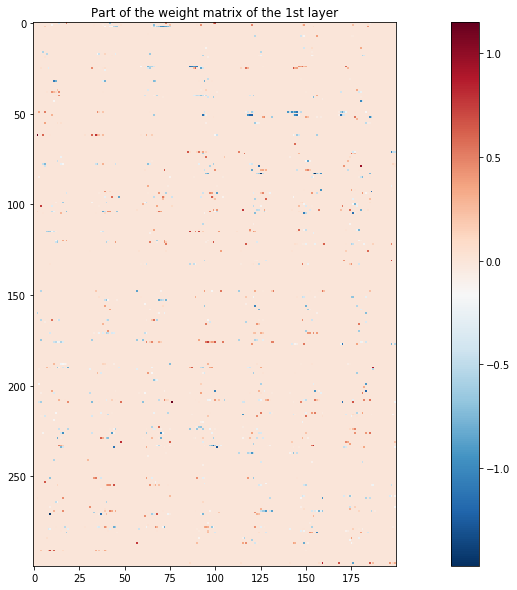

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# mask zero weights
log_alpha = (model.fc1.log_alpha.detach().cpu().numpy() < model.threshold).astype(np.float)
W = model.fc1.mu.detach().cpu().numpy()

# visualize part of the matrix
plt.figure(figsize=(20, 10))
plt.imshow((log_alpha * W)[:, 200:400], cmap='RdBu_r', interpolation=None)
plt.colorbar()
plt.title("Part of the weight matrix of the 1st layer")

Visualize sparsified weights reshaped to the image shape:

Text(0.5,1,'Weights reshaped to the image shape')

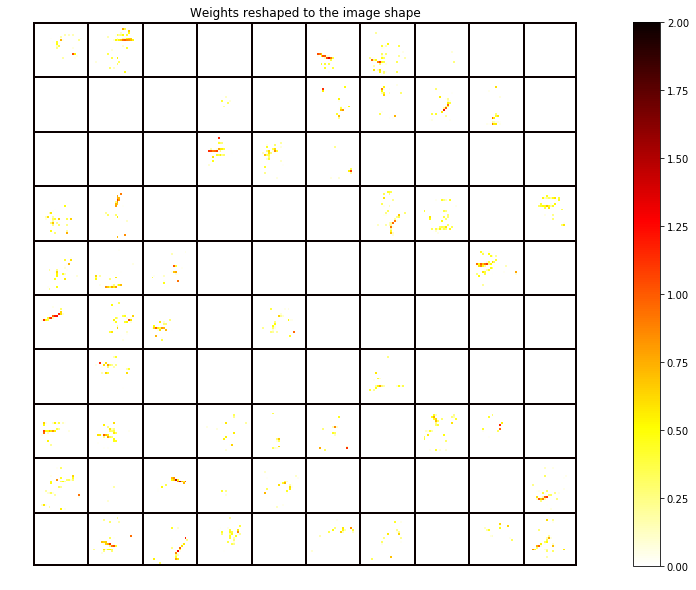

In [21]:
s = 0

z = np.zeros((28*10, 28*10))

for i in range(10):
    for j in range(10):
        s += 1
        z[i*28:(i+1)*28, j*28:(j+1)*28] =  np.abs((log_alpha * W)[s].reshape(28, 28))
        
z[::28] = 2
z[:, ::28] = 2
z[-1] = 2
z[:, -1] = 2
      
plt.figure(figsize=(20, 10))
plt.imshow(z, cmap='hot_r')
plt.colorbar()
plt.axis('off')
plt.title("Weights reshaped to the image shape")

Visualize $\log |\mu|$ and $\log \sigma$ of the weights (do it yourself):

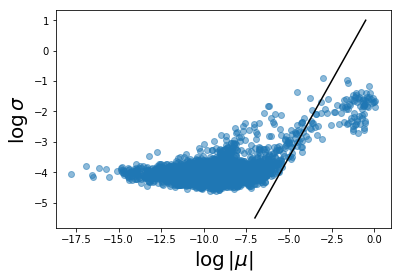

In [22]:
###########################################################
########         You Code should be here         ##########    
# Choose a submatrix of the weight matrix of the 1-st FC layer (about 100 x 100 elements)
# Scatter their log abs mu and log sigma (use plt.scatter)

plt.scatter(np.log(np.abs(model.fc1.mu.data.cpu().numpy()))[100:200, 100:200].ravel(),\
            model.fc1.log_sigma.data.cpu().numpy()[100:200, 100:200].ravel(),\
           alpha=0.5)
plt.xlabel("$\log \,|\mu|$", fontsize=20)
plt.ylabel("$\log \,\sigma$", fontsize=20)

ms = np.linspace(-7, -0.5, 100)
plt.plot(ms, ms+1.5, color="black")
###########################################################

## Compression with Sparse Matrixes

Let's check how efficient is weight compression using sparse matrix formats:

In [23]:
import scipy
import numpy as np
from scipy.sparse import csc_matrix, csc_matrix, coo_matrix, dok_matrix

row, col, data = [], [], []
M = list(model.children())[0].mu.data.cpu().numpy()
LA = list(model.children())[0].log_alpha.data.cpu().numpy()

for i in range(300):
    for j in range(28*28):
        if LA[i, j] < 3:
            row += [i]
            col += [j]
            data += [M[i, j]]

Mcsr = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcsc = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcoo = coo_matrix((data, (row, col)), shape=(300, 28*28))

In [24]:
np.savez_compressed('M_w', M)
scipy.sparse.save_npz('Mcsr_w', Mcsr)
scipy.sparse.save_npz('Mcsc_w', Mcsc)
scipy.sparse.save_npz('Mcoo_w', Mcoo)

In [25]:
ls -lah | grep npz

-rw-r--r-- 1 nadiinchi U_HSE  18K Jul  4 10:24 Mcoo_w.npz
-rw-r--r-- 1 nadiinchi U_HSE  17K Jul  4 10:24 Mcsc_w.npz
-rw-r--r-- 1 nadiinchi U_HSE  17K Jul  4 10:24 Mcsr_w.npz
-rw-r--r-- 1 nadiinchi U_HSE 858K Jul  4 10:24 M_w.npz


### If you have time left
* Implement Local Reparametrization Trick:
    * type code in use_lrt section in LinearSVDO layer and
    * choose use_lrt=True when creating a model
* Implement _structured_ Bayesian sparsification (slides 105-108)
* Compare SparseVD and ARD (slides 90-94) in terms of quality/compression ratio
* Play with hyperparameters like KL weight and threshold